<a href="https://colab.research.google.com/github/obeabi/AirlineSentiment/blob/main/Airline_Covnet_BertTokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Sentiment Dataset
## Written by Abiola Obembe
### Date: 2020-12-31

### Goal: Train a classifiier to predict customer sentiment from customer review text (using Bert tokenizer and pretrained word embeddings)


A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Step 1: Data Cleaning and Preprocessing

In [5]:
# install BERT library
!pip install bert-for-tf2
!pip install sentencepiece

print("Packages installed!")

Packages installed!


In [6]:
# Install tensorflow
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


print("installation complete!")
print(tf.__version__)


installation complete!
2.4.0


In [7]:
# Import dataset
dataset = pd.read_csv('Tweets.csv', encoding= 'latin1', engine='python', quoting = 1)

dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
# Drop columns not required
dataset.drop(columns = ['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
                        'airline', 'airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord',
                        'tweet_created','tweet_location','user_timezone'], axis = 1, inplace = True)
dataset.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn'tâ¦but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [9]:
#  Investigate the number of distinct sentiments
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

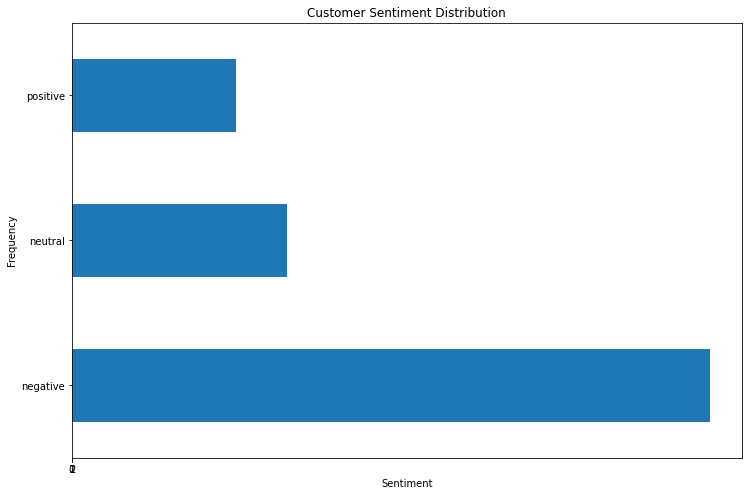

In [10]:
# Lets visualize the sentiments
count_classes = pd.value_counts(dataset['airline_sentiment'], sort = True)
count_classes.plot(kind = 'barh', rot = 0)
plt.title("Customer Sentiment Distribution")
plt.xticks(range(3))
plt.xlabel("Sentiment")
plt.ylabel('Frequency')
plt.show()

In [11]:
# Let us check for missing values in both columns
print(dataset.isnull().sum())

missing_values = dataset.isnull().sum().sum()
print('The total number of missing values in the dataframe is' , str(missing_values))

airline_sentiment    0
text                 0
dtype: int64
The total number of missing values in the dataframe is 0


In [20]:
## Data Cleaning

import re
from bs4 import BeautifulSoup
corpus = []


for i in range(0,dataset.shape[0]):
  reviews = BeautifulSoup(dataset['text'][i], 'lxml').get_text()
  reviews = re.sub(r"@[A-Za-z0-9]+", ' ', reviews)
  reviews = re.sub(r"https?://[A-Za-z0-9./]+", ' ', reviews)
  reviews = re.sub(r'[^a-zA-Z]', ' ',reviews)
  # Removing additional whitespaces
  reviews = re.sub(r" +", ' ', reviews)
  corpus.append(reviews)
  

In [21]:
# Let's examine the corpus
corpus[0:5]

[' What said ',
 ' plus you ve added commercials to the experience tacky ',
 ' I didn t today Must mean I need to take another trip ',
 ' it s really aggressive to blast obnoxious entertainment in your guests faces they have little recourse',
 ' and it s a really big bad thing about it']

In [22]:
# Let us encode the labels into integers 
from sklearn import preprocessing 
  
# label_encoder 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dataset['airline_sentiment']= label_encoder.fit_transform(dataset['airline_sentiment']) 
  
dataset['airline_sentiment'].unique() 

array([1, 2, 0])

In [60]:
dataset.head()

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


## STEP 2: Tokenization with BERT

In [23]:
# Tokenization: BERT
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1", trainable= False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = FullTokenizer(vocab_file, do_lower_case)


In [24]:
# Create function to tokenize text
def encode_sentence(sent):
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [25]:
data_inputs = [encode_sentence(sentence) for sentence in corpus ]

In [26]:
# Let's examine the tokenizer in action
encode_sentence("My dog loves oranges.")

[2026, 3899, 7459, 4589, 2015, 1012]

In [28]:
# Let's examine the tokenizer in action
encode_sentence("Dogs loves bones but hates oranges.")

[6077, 7459, 5944, 2021, 16424, 4589, 2015, 1012]

In [29]:
# create dataset
data_labels = dataset.airline_sentiment.values

data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]

np.random.shuffle(data_with_len)
data_with_len.sort(key= lambda x: x[2])

sorted_all = [(sent_lab[0], sent_lab[1])

              for sent_lab in data_with_len if sent_lab[2]> 2]

all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types = (tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes= ((None,), ()   ))



In [30]:
# Inspect dataset
next(iter(all_batched))

(<tf.Tensor: shape=(32, 3), dtype=int32, numpy=
 array([[ 2205,  2397,  3462],
        [ 1040,  2213,  2741],
        [ 2017,  2128,  6160],
        [ 2206,  2026,  2919],
        [ 2469,  4067,  2017],
        [18168,  2290,  2633],
        [ 1045,  2066,  3582],
        [ 2017,  4364, 11891],
        [ 5319,  4283,  4312],
        [ 1040,  2213,  2741],
        [ 2115,  2326, 19237],
        [ 2017,  4364,  2600],
        [ 4283,  2033,  2205],
        [ 2589,  2004,  7303],
        [ 2307,  4067,  2017],
        [ 2017,  2024,  6659],
        [ 2288,  2009,  4283],
        [ 2763,  2025,  4902],
        [ 5409,  3325,  2412],
        [ 7929,  4067,  2017],
        [ 2748,  2064,  2079],
        [ 2323,  1045,  3613],
        [ 2074,  2741,  2009],
        [ 2054,  2055,  3462],
        [ 2053,  2272,  2006],
        [ 2202,  2033,  2182],
        [ 2053, 13204,  2015],
        [ 2026, 10007, 13403],
        [ 2017,  8239, 11891],
        [ 2307,  4067,  2017],
        [ 1057,  4364,

In [31]:
# split dataset into train and test set
import math
NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES// 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# Step 4: Build the Model

In [32]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,emb_dim)

        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3, padding="valid", activation="relu")
        
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding="valid", activation="relu")
        
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [33]:
# Configuration details
VOCAB_SIZE = len(tokenizer.vocab)

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 3

DROPOUT_RATE = 0.25

NB_EPOCHS = 10

In [34]:
# Let's DEFINE THE LOSS for the model
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [36]:
# Create a checkpoint
checkpoint_path = "./drive/My Drive/projects/Bert_for_NLP/ckpt/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")



In [37]:
class MyCustomCallback(tf.keras.callbacks.Callback):

   def on_epoch_end(self, epoch, logs = None):
     ckpt_manager.save()
     print("Checkpoint saved at {}. ".format(checkpoint_path))

In [38]:
# train model
Dcnn.fit(train_dataset,epochs=NB_EPOCHS, callbacks= [MyCustomCallback()])

Epoch 1/10
404/404 [==============================] - 34s 82ms/step - loss: 0.7809 - sparse_categorical_accuracy: 0.6250
Checkpoint saved at ./drive/My Drive/projects/Bert_for_NLP/ckpt/. 
Epoch 2/10
404/404 [==============================] - 34s 83ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8220
Checkpoint saved at ./drive/My Drive/projects/Bert_for_NLP/ckpt/. 
Epoch 3/10
404/404 [==============================] - 34s 83ms/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9162
Checkpoint saved at ./drive/My Drive/projects/Bert_for_NLP/ckpt/. 
Epoch 4/10
404/404 [==============================] - 33s 82ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9596
Checkpoint saved at ./drive/My Drive/projects/Bert_for_NLP/ckpt/. 
Epoch 5/10
404/404 [==============================] - 34s 83ms/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9751
Checkpoint saved at ./drive/My Drive/projects/Bert_for_NLP/ckpt/. 
Epoch 6/10
404/404 [==============================] - 33s 82

In [39]:
# Evaluate model
results = Dcnn.evaluate(test_dataset)
print(results)

44/44 [==============================] - 1s 9ms/step - loss: 1.2804 - sparse_categorical_accuracy: 0.6911
[1.2803740501403809, 0.6910511255264282]


In [62]:
# Make predictions
def get_prediction(sentence):
  tokens = encode_sentence(sentence)
  inputs = tf.expand_dims(tokens, 0)

  output = Dcnn(inputs, training= False)
  sentiment = output

  for i in range(len(sentiment)):
    if np.argmax(sentiment) == 0:
      print("The sentiment is positive")

    elif np.argmax(sentiment) == 1:
      print("The sentiment is negative")

    else:
        print('The sentiment is neutral')


In [63]:
x= get_prediction("I'd rather not do that agaian.")


The sentiment is positive
